# Гаркавый Андрей, 494 группа

Задание - пройти контест на Kaggle на распознавание фамилий.

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("last_name_data/linear_train.txt")
test = pd.read_csv("last_name_data/linear_test.txt")
sample_submission = pd.read_csv("last_name_data/linear_ans_example.txt")

In [3]:
train.head(10)

last name  y
0  Аалтонен  1
1       Аар  0
2     Аарон  0
3     ААРОН  0
4    Аарона  0
5    Аарона  1
6    Аароне  0
7   Ааронов  0
8    Аахена  0
9   Абабков  1

In [4]:
from sklearn.feature_extraction.text import HashingVectorizer
from scipy import interp
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [6]:
def convert_to_hashing_features(hv, X):
    return hv.fit_transform(X)

In [8]:
def cross_val_roc_auc(classifier, X, y):
    cv = StratifiedKFold(n_splits=6)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    i = 0
    plt.figure(figsize=(15, 15))
    for (train, test), color in zip(cv.split(X, y), colors):
        probas_ = classifier.fit(X[train], y.iloc[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def try_coefs(model, hv, train, frac):
    train_part = train.sample(frac=frac, random_state=42)
    X_train = convert_to_hashing_features(hv, train_part['last name'])
    y_train = train_part['y'] * 2 - 1
    cross_val_roc_auc(model, X_train, y_train)

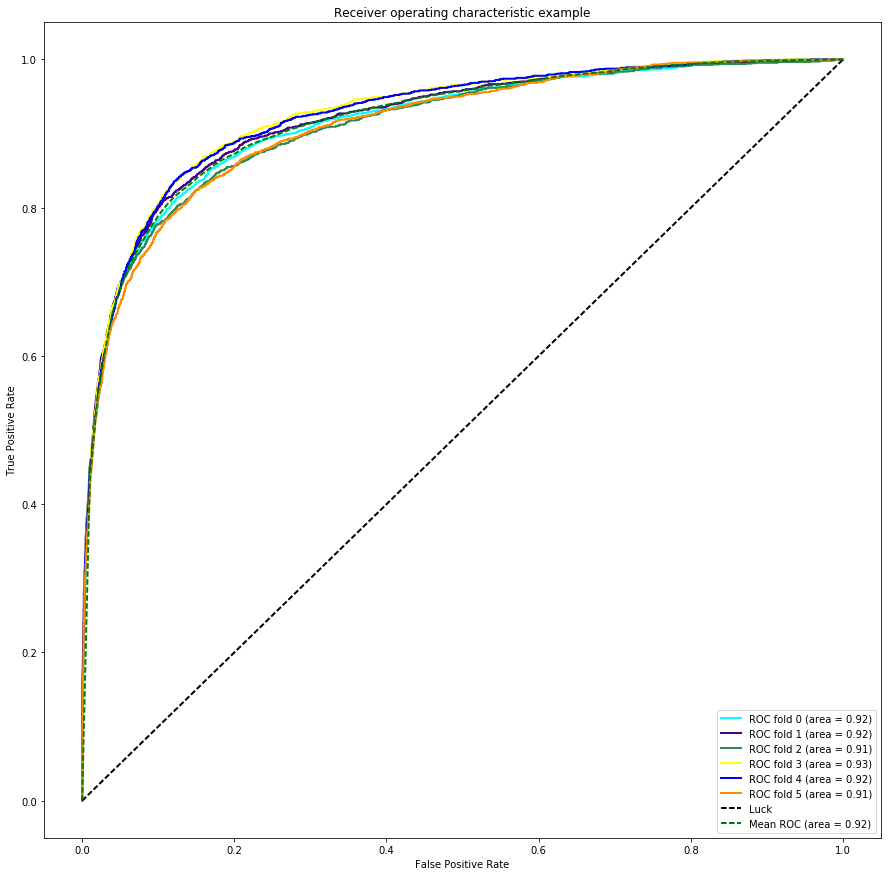

In [14]:
model = LogisticRegression(C=50, n_jobs=2)
hv = HashingVectorizer(lowercase=False, n_features=2 ** 22, analyzer='char_wb', ngram_range=(1,6))
frac = 1.0
train_part = train.sample(frac=frac, random_state=42)
try_coefs(model,
          hv,
          train,
          frac)

In [15]:
X_train = convert_to_hashing_features(hv, train_part['last name'])
y_train = train_part['y'] * 2 - 1

In [16]:
X_test = convert_to_hashing_features(hv, test['last name'])

In [17]:
y_test = model.fit(X_train, y_train).predict_proba(X_test)[:,1]

In [18]:
ans = pd.DataFrame()
ans['Id'] = list(range(len(y_test)))
ans['Answer'] = y_test
ans.head(5)

Id    Answer
0   0  0.665996
1   1  0.085040
2   2  0.103813
3   3  0.028260
4   4  0.092818

In [19]:
ans.to_csv("garkavyy_last_name_logistic_regression.txt", sep=',', index=False)